In [1]:
import os
import torch
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # Use GPU
os.environ["TOKENIZERS_PARALLELISM"] = "false"  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



/home/stu10/s18/kd4849/miniconda3/envs/idai610/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: cuda


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

2025-04-07 06:12:35.324008: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 06:12:35.385259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 06:12:37.277732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load data and apply some preprocesing
def load_data(det):
    categories = ['Happy', 'Sad', 'Neutral', 'Surprise', 'Angry']
    data = []
    labels = []
    
    for category in categories:
        folder_path = os.path.join(det, category)
        for img_name in os.listdir(folder_path):
            if 'ipynb_checkpoints' not in img_name:
                img_path = os.path.join(folder_path, img_name)
                img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
                img_array = image.img_to_array(img)
                img_array = preprocess_input(img_array)  # Preprocess input using the ResNet preprocess_input
                data.append(img_array)
                labels.append(categories.index(category))  # Assign label based on the folder name
    
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

# Path to your dataset
det = 'Face'

# Load the dataset
X, y = load_data(det)



In [4]:
# 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# One-hot encode to convert the labels
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)



In [5]:
# Define model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")



2025-04-07 06:13:39.128232: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 200s 681ms/step - accuracy: 0.5613 - loss: 1.3238 - val_accuracy: 0.6979 - val_loss: 0.7335
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 173s 622ms/step - accuracy: 0.6824 - loss: 0.7771 - val_accuracy: 0.7143 - val_loss: 0.6750
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 194s 702ms/step - accuracy: 0.7124 - loss: 0.7034 - val_accuracy: 0.7238 - val_loss: 0.6522
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 208s 753ms/step - accuracy: 0.7312 - loss: 0.6575 - val_accuracy: 0.7391 - val_loss: 0.6429
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 183s 661ms/step - accuracy: 0.7481 - loss: 0.6269 - val_accuracy: 0.7254 - val_loss: 0.6545
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 196s 709ms/step - accuracy: 0.7599 - loss: 0.5987 - val_accuracy: 0.7375 - val_loss: 0.6385
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 216s 781ms/step - accuracy: 0.7749 - loss: 0.5563 - val_accuracy: 0.7543 - val_loss: 0.6097
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 184s 662ms/step - accuracy: 0.7760 -

In [6]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)



60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 506ms/step


In [7]:
#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[297  36  68   6  10]
 [ 28 194 166   4  24]
 [ 21  41 283   3   8]
 [  1   2  15 303  20]
 [ 11  20  21  13 303]]


In [8]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Happy', 'Sad', 'Neutral', 'Surprise', 'Angry']))


Classification Report:
              precision    recall  f1-score   support

       Happy       0.83      0.71      0.77       417
         Sad       0.66      0.47      0.55       416
     Neutral       0.51      0.79      0.62       356
    Surprise       0.92      0.89      0.90       341
       Angry       0.83      0.82      0.83       368

    accuracy                           0.73      1898
   macro avg       0.75      0.74      0.73      1898
weighted avg       0.75      0.73      0.73      1898



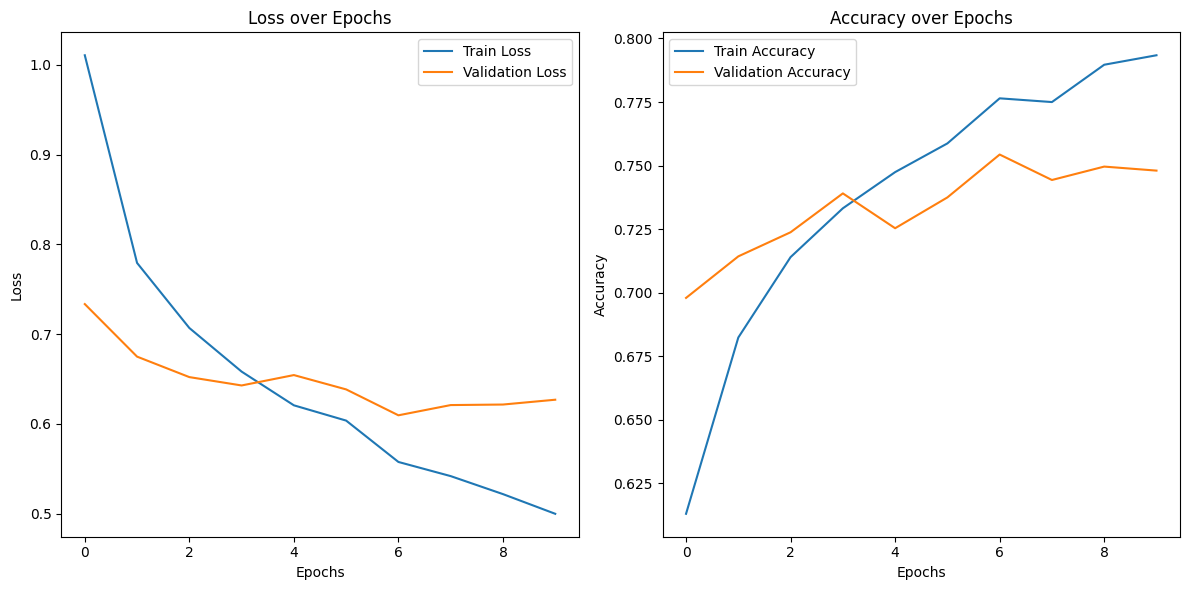

In [9]:
plt.figure(figsize=(12, 6))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
